# Implicit Feedback


There are two types of feedback on which most recommender systems would be based. Explicit feedback deals with clear and quantified expression of preferences by a user, in terms of both likes and dislikes. An excellent example would be ratings. However, much more common is implicit feedback, where users provide some positive signals, but the contrast to negative signals may be absent or at least much less evident. An example would be clicks on links or views when browsing.  In this tutorial, we will focus on implicit feedback.

## 1. Setup

In [32]:
import os
import sys
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import cornac
from cornac.utils import cache
from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
from cornac.models import MF, BPR, WMF

!pip install tensorflow
import tensorflow as tf

print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")
print(f"Tensorflow version: {tf.__version__}")

SEED = 42
VERBOSE=False

Cornac version: 2.3.0
Tensorflow version: 2.19.0



## 2. Weighted Matrix Factorization (WMF)

We use the term **adoption matrix** to refer to interactions between users and items. In the case of explicit feedback, it is the rating matrix, while in the case of implicit feedback, it can be a matrix of click counts or binary values.

Weighted Matrix Factorization predicts the adoption of user $i$ to item $j$ using the inner product of user and item factors:

$$
\hat{p}_{i,j} = \mathbf{u}_i^T \mathbf{v}_j
$$

The difference between Weighted MF and Original MF is that WMF tries to predict *unobserved* adoptions, whereas MF ignores them during training. The convention in the **Cornac** library is to derive observed and unobserved adoptions from the rating matrix as follows:

\begin{equation}
p_{i,j} = 
\begin{cases} 
    r_{i, j}, & \text{if } r_{i,j} > 0 \\
    0, & \text{otherwise} 
\end{cases}
\end{equation}

The important principle is that WMF usually assigns a higher confidence weight when fitting *observed* adoptions than when fitting *unobserved* adoptions. There are several ways to introduce the confidence scores. Here we use the convention by the **Cornac** library, which implements the following rules:

\begin{equation}
c_{i,j} = 
\begin{cases} 
    a, & \text{if } r_{i,j} > 0 \\
    b, & \text{otherwise}
\end{cases}
\end{equation}

Concretely, WMF minimizes the following loss function:

$$
\mathcal{L}(\mathbf{U,V}|\lambda) = \frac{1}{2} \sum_{i,j} c_{i,j} (p_{i,j} - \mathbf{u}_i^T \mathbf{v}_j)^2 + \frac{\lambda}{2} \sum_{i=1}^{N} ||\mathbf{u}_i||^2 + \frac{\lambda}{2} \sum_{j=1}^{M} ||\mathbf{v}_j||^2
$$

Let's now compare how WMF and MF are different.

In [33]:
K = 50
wmf = WMF(k=K, max_iter=100, a=1.0, b=0.01, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01,
          verbose=VERBOSE, seed=SEED, name=f"WMF(K={K})")
mf = MF(k=K, max_iter=20, learning_rate=0.01, lambda_reg=0.01, 
        verbose=VERBOSE, seed=SEED, name=f"MF(K={K})")

eval_metrics = [
  cornac.metrics.RMSE(), 
  cornac.metrics.AUC(),
  cornac.metrics.Precision(k=10),
  cornac.metrics.Recall(k=10),
  cornac.metrics.FMeasure(k=10),
  cornac.metrics.NDCG(k=[10, 20, 30]),
  cornac.metrics.MRR(),
  cornac.metrics.MAP()
]

data = movielens.load_feedback(variant="100K")
rs = RatioSplit(data, test_size=0.2, seed=SEED)

cornac.Experiment(eval_method=rs, models=[wmf, mf], metrics=eval_metrics).run()


TEST:
...
          |   RMSE |    AUC |  F1@10 |    MAP |    MRR | NDCG@10 | NDCG@20 | NDCG@30 | Precision@10 | Recall@10 | Train (s) | Test (s)
--------- + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------- + ------------ + --------- + --------- + --------
WMF(K=50) | 1.1012 | 0.8980 | 0.1403 | 0.1697 | 0.4585 |  0.2413 |  0.2526 |  0.2713 |       0.2020 |    0.1456 |    3.4084 |   1.4529
MF(K=50)  | 0.8909 | 0.6573 | 0.0454 | 0.0564 | 0.2288 |  0.1021 |  0.0942 |  0.0967 |       0.0928 |    0.0358 |    0.1431 |   1.6337



As we can observe, the strength of the MF model is the ability to predict ratings well (lower RMSE). However, WMF model is designed to rank items, by fitting binary adoptions, thus it outperforms MF across all the listed ranking metrics. 

## 3. Bayesian Personalized Ranking (BPR)

Implicit feedback can also be turned into another form of expression, namely ordinal preferences.  Given an *observed* feedback $(i, j)$ between user $i$ and item $j$, another item $l$ (with *no observed interaction* with user $i$) is coupled with the pair to form a triple $(i, j, l)$.  Thus, there are now notions of *positive* and *negative* items.  The training data consists of ordinal triples $D_S = \{(i, j, l) | r_{ij} \in \mathbf{R}^+ \land r_{il} \in \mathbf{R}^-\}$.

BPR maximizes the joint probability over all triples:

$$ \prod_{(i,j,l) \in D_S} p(j >_{i} l) = \prod_{(i,j,l) \in D_S} \sigma(\mathbf{u}_i^T \mathbf{v}_j - \mathbf{u}_i^T \mathbf{v}_l) $$

where $\sigma(*)$ is the logistic *sigmoid* function and the preference scoring function is the inner product of user and item latent factors, inspired by the matrix factorization method.

By minimizing *negative log-likelihood* with *l2-regularization*, we arrive at the following loss function:

$$ \mathcal{L}(\mathbf{U,V}|\lambda) = \sum_{i,j,l} \ln (1 + \exp\{-(\mathbf{u}_i^T \mathbf{v}_j - \mathbf{u}_i^T \mathbf{v}_l)\}) + \frac{\lambda}{2} \sum_{i=1}^{N} ||\mathbf{u}_i||^2 + \frac{\lambda}{2} \sum_{j=1}^{M} ||\mathbf{v}_j||^2 $$

Let's compare the two models BPR and WMF.

In [34]:
K = 50
bpr = BPR(k=K, max_iter=200, learning_rate=0.01, lambda_reg=0.001, 
          verbose=VERBOSE, seed=SEED, name=f"BPR(K={K})")
wmf = WMF(k=K, max_iter=100, a=1.0, b=0.01, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01,
          verbose=VERBOSE, seed=SEED, name=f"WMF(K={K})")

rs = RatioSplit(data, test_size=0.2, seed=SEED, verbose=VERBOSE)
cornac.Experiment(eval_method=rs, models=[bpr, wmf], metrics=eval_metrics).run()


TEST:
...
          |   RMSE |    AUC |  F1@10 |    MAP |    MRR | NDCG@10 | NDCG@20 | NDCG@30 | Precision@10 | Recall@10 | Train (s) | Test (s)
--------- + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------- + ------------ + --------- + --------- + --------
BPR(K=50) | 1.5631 | 0.9356 | 0.2197 | 0.2667 | 0.6320 |  0.3865 |  0.3856 |  0.4030 |       0.3236 |    0.2229 |    3.1492 |   2.0085
WMF(K=50) | 1.1012 | 0.8980 | 0.1403 | 0.1697 | 0.4585 |  0.2413 |  0.2526 |  0.2713 |       0.2020 |    0.1456 |    3.4999 |   1.5182



BPR only tries to preserve the ordinal constraints without learning to predict the rating values.  Thus, RMSE is not the right metric to evaluate BPR model.   Minimizing the loss function of BPR is analogous to maximizing AUC, therefore, we expect BPR to do well on that metric.

Both BPR and WMF models are designed to obtain good performances in terms of ranking metrics.  With reasonable efforts for hyper-parameter tuning, we should see comparable performance between the two models.  

BPR focuses on ranking, modeling the relative preference between items based on implicit feedback.
WMF is designed for matrix completion, aiming to predict the missing entries in a user-item interaction matrix. It uses explicit ratings (if available), but it can also be adapted for implicit feedback by treating missing values as negative feedback.

## 4. Interpreting Latent Factors

Both presented models (WMF and BPR) are based on the matrix factorization technique, let us see how the latent factors could give us some information about how items are associated with one another, as well as which items tend to be associated with a particular factor.

In [43]:
# Download some information of MovieLens 100K dataset
item_df = pd.read_csv(
  cache("http://files.grouplens.org/datasets/movielens/ml-100k/u.item"), 
  sep="|", encoding="ISO-8859-1",
  names=["ItemID", "Title", "Release Date", "Video Release Date", "IMDb URL", 
         "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", 
         "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", 
         "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]
).set_index("ItemID").drop(columns=["Video Release Date", "IMDb URL", "unknown"])

In [44]:
item_df.head()

,Title,Release Date,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
ItemID,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


### WMF Latent Factors

Below is the variance of each latent dimension across different items.  If a factor or dimension has higher variance, it is better at discriminating among different items.  Conversely, if the variance of a factor is too small, it implies that most items would have a similar value for that factor.

C:\Users\m.varo\AppData\Local\Temp\ipykernel_20636\118022542.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Factor", y="Variance", data=var_df, palette="ch:.25", ax=ax);


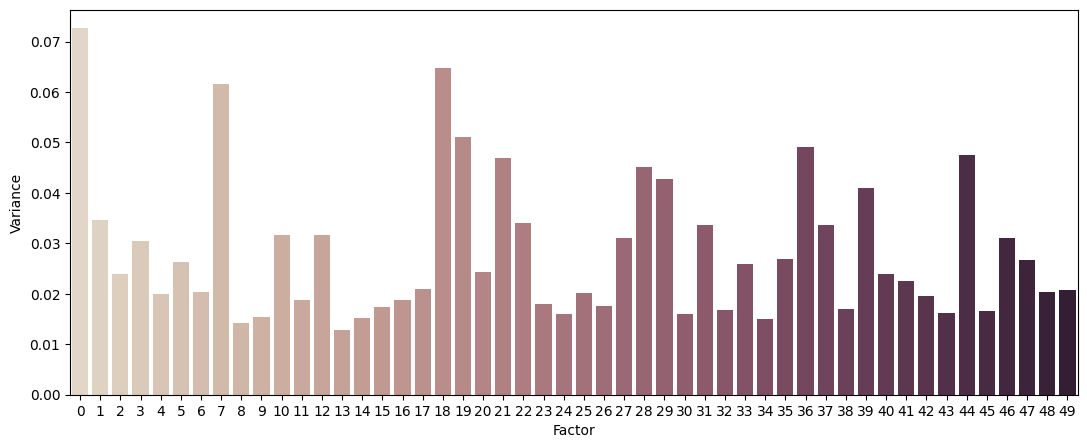

In [36]:
var_df = pd.DataFrame({"Factor": np.arange(K), "Variance": np.var(wmf.V, axis=0)})
fig, ax = plt.subplots(figsize=(13, 5))
sns.barplot(x="Factor", y="Variance", data=var_df, palette="ch:.25", ax=ax);

In [37]:
!pip install adjustText
from adjustText import adjust_text

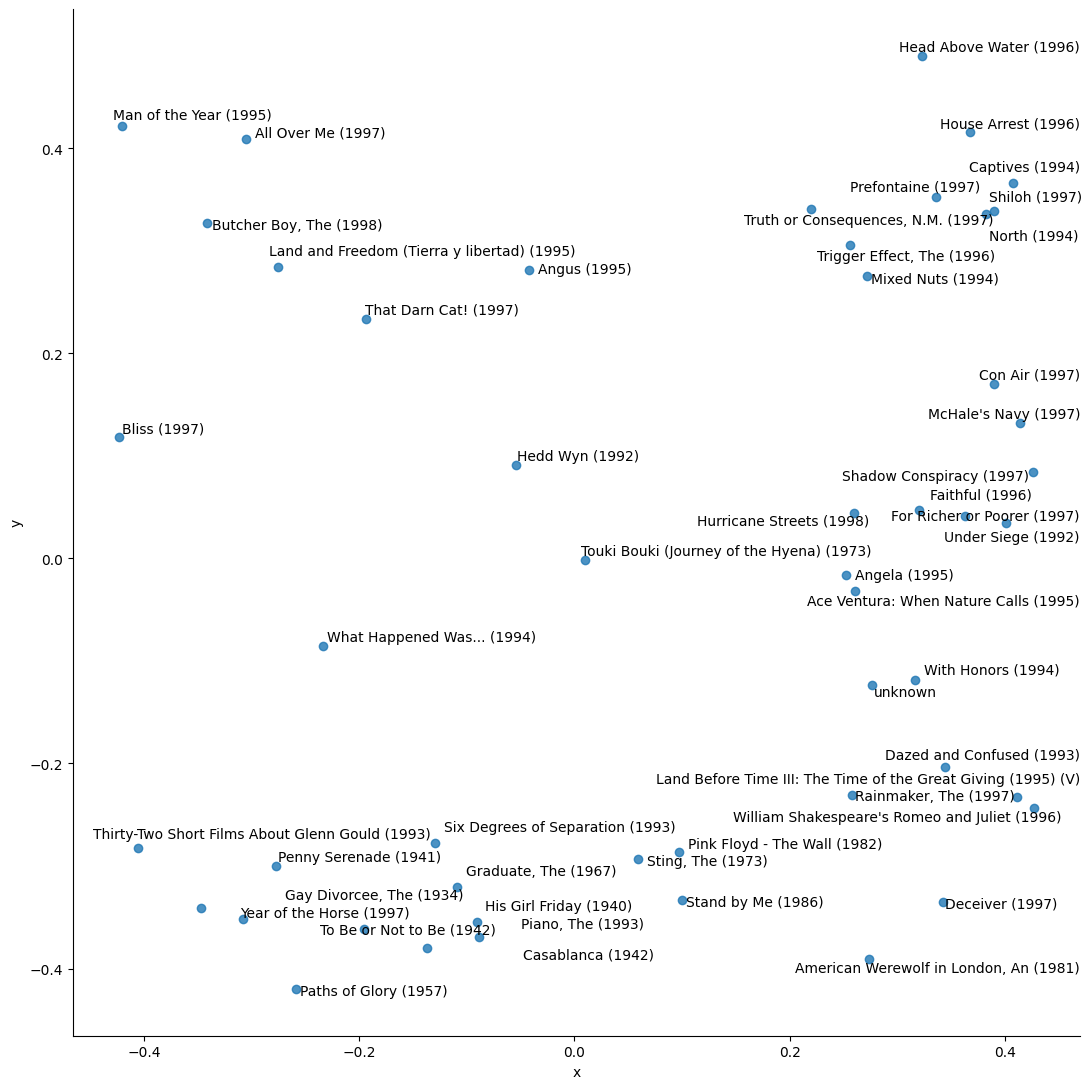

In [46]:
TOP2F = (0, 18)
SAMPLE_SIZE = 50

rng = np.random.RandomState(SEED)
sample_inds = rng.choice(np.arange(wmf.V.shape[0]), size=SAMPLE_SIZE, replace=False)
sample_df = pd.DataFrame(data=wmf.V[sample_inds][:, TOP2F], columns=["x", "y"])

sns.lmplot(x="x", y="y", data=sample_df, height=11.0, fit_reg=False)
item_idx2id = list(wmf.train_set.item_ids)
titles = item_df.loc[[int(item_idx2id[i]) for i in sample_inds]]["Title"].values
adjust_text(
  [plt.text(*sample_df.loc[i].values, titles[i], size=10) for i in range(len(titles))]
);

### Interpreting Recommendations of WMF

Let's pick a user and see what the top-K recommendations by WMF model are.  

In [39]:
UIDX = 0
TOPK = 5

item_id2idx = wmf.train_set.iid_map
item_idx2id = list(wmf.train_set.item_ids)

recommendations, scores = wmf.rank(UIDX)
print(f"\nTOP {TOPK} RECOMMENDATIONS:")
print("Scores:", scores[recommendations[:TOPK]])
item_df.loc[[int(item_idx2id[i]) for i in recommendations[:TOPK]]]


TOP 5 RECOMMENDATIONS:
Scores: [4.513593  4.4660506 4.3170953 4.2535796 4.202482 ]


,Title,Release Date,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
ItemID,,,,,,,,,,,,,,,,,,,,
318,Schindler's List (1993),01-Jan-1993,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
50,Star Wars (1977),01-Jan-1977,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
496,It's a Wonderful Life (1946),01-Jan-1946,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
64,"Shawshank Redemption, The (1994)",01-Jan-1994,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
169,"Wrong Trousers, The (1993)",01-Jan-1993,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


Let's try to explain why the WMF model recommends the movie **Star Wars (1977)**, *ItemID* = 50 to the user.

In [40]:
REC_ID = 50
print("Recommended movie:", item_df.loc[REC_ID].Title)
rec_idx = item_id2idx[str(REC_ID)]

U, V, lbd = wmf.U, wmf.V, wmf.lambda_v
pi = wmf.train_set.matrix[UIDX].A.ravel()
ci = (pi > 0) * (wmf.a - wmf.b) + wmf.b

Wu = np.linalg.inv(V.T.dot(np.diag(ci)).dot(V) + lbd * np.eye(wmf.k))
sim = V[rec_idx].dot(Wu).dot(V.T)
contribution = sim * ci * pi

print("\nTop contributors:")
df = defaultdict(list)
for idx in np.argsort(contribution)[-TOPK:][::-1]:
  df["ItemID"].append(item_df.loc[[int(item_idx2id[idx])]].index.values[0])
  df["Title"].append(item_df.loc[[int(item_idx2id[idx])]]["Title"].values[0])
  df["Similarity"].append(sim[idx])
  df["Confidence"].append(ci[idx])
  df["Adoption"].append(pi[idx])
  df["Contribution"].append(contribution[idx])
pd.DataFrame.from_dict(df)

Recommended movie: Star Wars (1977)

Top contributors:


,ItemID,Title,Similarity,Confidence,Adoption,Contribution
0,258,Contact (1997),0.241294,1.0,4.0,0.965174
1,237,Jerry Maguire (1996),0.231626,1.0,4.0,0.926502
2,971,Mediterraneo (1991),0.205753,1.0,4.0,0.823011
3,56,Pulp Fiction (1994),0.140438,1.0,5.0,0.702191
4,690,Seven Years in Tibet (1997),0.115902,1.0,4.0,0.463607




- **ItemID**: Unique identifier for each movie
- **Title**: Name of the movie and its release year
- **Similarity**: How similar this movie is to the target movie (0-1 scale)
- **Confidence**: The algorithm's confidence in this similarity (all 1.0 here)
- **Adoption**: How much the user has engaged with this movie (rating or view count)
- **Contribution**: Combined score showing how much this movie influences the recommendation

## How the Recommendation Works:

1. The code calculates a similarity score between the target movie and all other movies in the database.

2. It then weights this similarity by:
   - How much the user has interacted with each movie (`Adoption`)
   - The algorithm's confidence in those interactions (`Confidence`)

3. The final `Contribution` score determines which movies most influence the recommendation.

## Interpretation of Results:

The top contributing movies to the recommendation of movie ID 50 are:
1. **Contact (1997)** - Highest contribution (0.965)
2. **Jerry Maguire (1996)** - Close second (0.927)
3. **Mediterraneo (1991)** - Moderate contribution (0.823)
4. **Pulp Fiction (1994)** - Lower but still significant (0.702)
5. **Seven Years in Tibet (1997)** - Smallest contribution (0.464)

This suggests that if a user has watched and liked these movies (especially the top ones), they're more likely to enjoy movie ID 50, according to the recommendation algorithm.

The WMF model is particularly good at handling implicit feedback (like views or watch time) rather than explicit ratings, which explains the confidence and adoption metrics in the table.

### BPR Latent Factors

Below is the variance of each latent dimension.

C:\Users\m.varo\AppData\Local\Temp\ipykernel_20636\1472579105.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


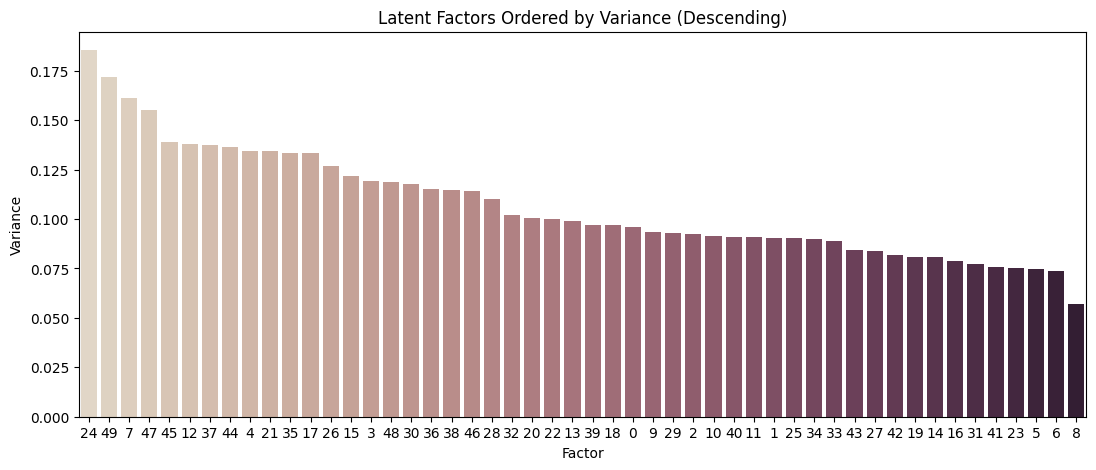

In [41]:
var_df = pd.DataFrame({"Factor": np.arange(K), "Variance": np.var(bpr.i_factors, axis=0)})
var_df = var_df.sort_values("Variance", ascending=False)

# Plot with ordered factors
plt.figure(figsize=(13, 5))
sns.barplot(
    x="Factor", 
    y="Variance", 
    data=var_df, 
    order=var_df["Factor"],  # This ensures the sorted order is maintained
    palette="ch:.25", 
    legend=False
)

plt.title("Latent Factors Ordered by Variance (Descending)")
plt.xlabel("Factor")
plt.ylabel("Variance")
plt.show()


This code creates a bar plot showing the variance of latent factors in a Bayesian Personalized Ranking (BPR) model. Here's how to interpret it:

- **X-axis (Factor)**: Represents each latent dimension (from 0 to K-1) in your factorization model
- **Y-axis (Variance)**: Shows how much each latent factor varies across items

1. **High Variance Factors**:
   - These are the most important dimensions in your model
   - They capture strong patterns in user preferences
   - Example: If factor 7 has high variance, it might represent a major genre preference (like "sci-fi vs. romance")

2. **Low Variance Factors**:
   - These contribute less to recommendations
   - May represent subtle preferences or could be noise
   - Might be candidates for removal to simplify the model

3. **Patterns to Look For**:
   - **Steep drop-off**: Shows where additional factors provide diminishing returns
   - **Plateau**: Suggests how many factors are truly needed (the "elbow point")

## Practical Implications

1. **Model Optimization**:
   - You might reduce dimensionality by keeping only factors above a certain variance threshold
   - Helps prevent overfitting by removing noisy dimensions

2. **Understanding Recommendations**:
   - The highest-variance factors explain most of the recommendation behavior
   - You could examine item loadings on these factors to understand what they represent

3. **Comparison Between Models**:
   - Different algorithms will show different variance patterns
   - More efficient models concentrate variance in fewer factors


The shape of this variance plot helps you understand how your latent space is structured and where the most important patterns in your recommendation data lie.

In [52]:
genres = list(item_df.columns)[2:]
genres

['Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

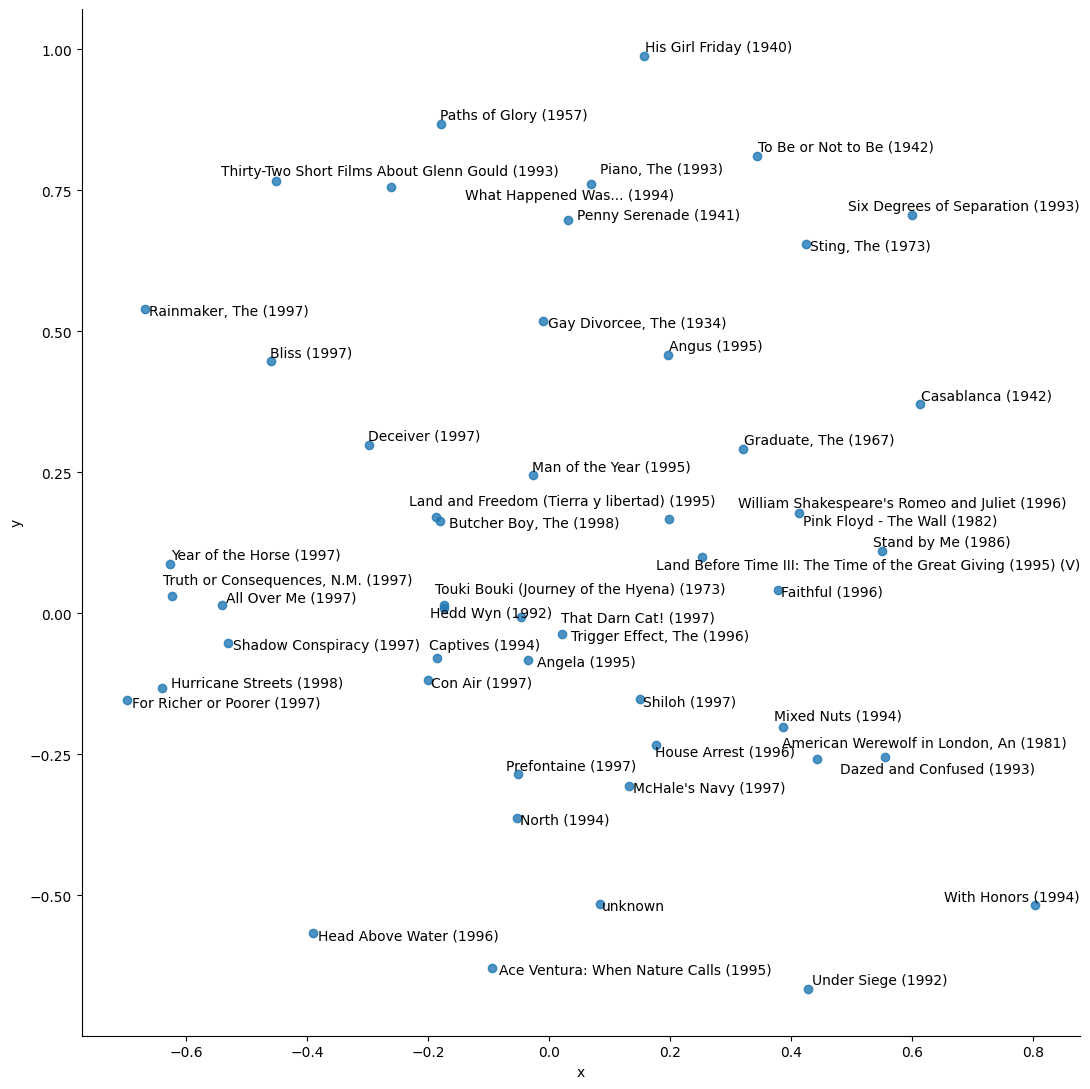

In [ ]:
TOP2F = (24, 49)
SAMPLE_SIZE = 

rng = np.random.RandomState(SEED)
sample_inds = rng.choice(np.arange(bpr.i_factors.shape[0]), size=SAMPLE_SIZE, replace=False)
sample_df = pd.DataFrame(data=bpr.i_factors[sample_inds][:, TOP2F], columns=["x", "y"])

sns.lmplot(x="x", y="y", data=sample_df, height=11.0, fit_reg=False)
item_idx2id = list(bpr.train_set.item_ids)

titles = item_df.loc[[int(item_idx2id[i]) for i in sample_inds]]["Title"].values
adjust_text(
  [plt.text(*sample_df.loc[i].values, titles[i], size=10) for i in range(len(titles))]
);

This code visualizes how items (movies) are positioned in the latent space defined by the two most important factors from your BPR (Bayesian Personalized Ranking) model. Here's why it's useful:

1. **`TOP2F = (24, 49)`**  
   - Selects the two highest-variance latent factors (from your previous variance analysis)
   - These factors explain the most variance in user preferences

2. **Random Sampling (`SAMPLE_SIZE = 50`)**  
   - Takes a representative subset of items for cleaner visualization
   - Avoids overcrowding the plot while maintaining diversity

   - Positions each movie based on its values for the two selected factors
   - Reveals natural clustering of similar movies in latent space

### What This Visualization Reveals:
- **Item Relationships**: Movies close together are similar according to the model
- **Factor Interpretation**: By seeing which movies cluster together, you can hypothesize what each latent dimension represents (e.g., one axis might separate dramas from action movies)
- **Model Quality Check**: Good models show meaningful clustering (e.g., all sci-fi movies in one region)

### Practical Applications:
1. **Debugging Recommendations**:  
   If a bad recommendation appears, check its position relative to movies the user likes

2. **Understanding User Preferences**:  
   Users who prefer movies in a specific region of the plot share similar tastes

3. **Dimensionality Reduction**:  
   Confirms whether 2 factors can capture meaningful structure (or if more are needed)

### Example Insights You Might Gain:
- If Factor 24 separates classic films from modern ones
- If Factor 49 separates artsy films from mainstream blockbusters
- Whether certain genres form clear clusters
- Whether the model captures nuanced relationships (e.g., separating dark comedies from pure comedies)

This is particularly valuable because while latent factors are mathematically precise, visualizations like this help translate them into human-interpretable concepts.

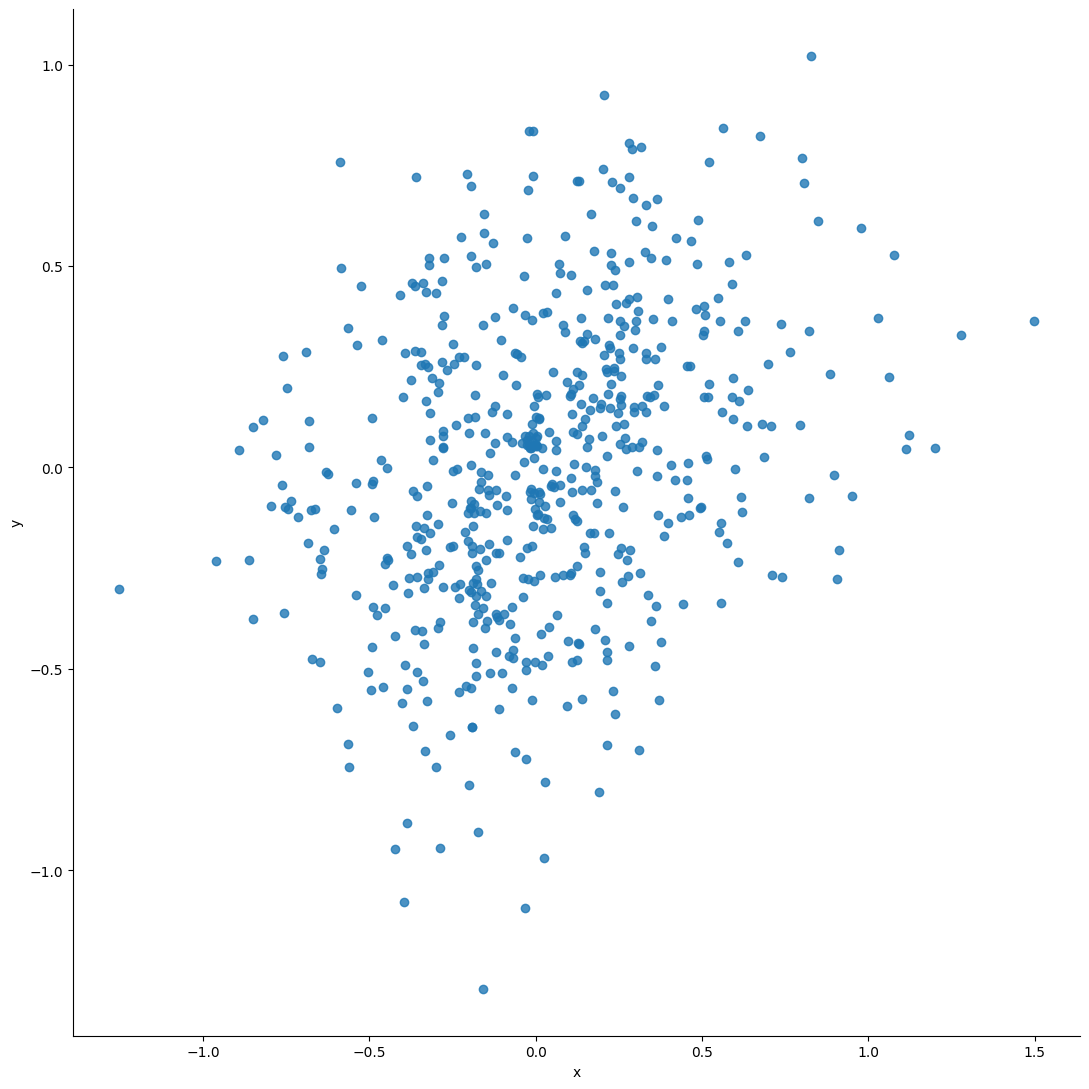

In [63]:
TOP2F = (47, 45)
SAMPLE_SIZE = 600

rng = np.random.RandomState(SEED)
sample_inds = rng.choice(np.arange(bpr.i_factors.shape[0]), size=SAMPLE_SIZE, replace=False)
sample_df = pd.DataFrame(data=bpr.i_factors[sample_inds][:, TOP2F], columns=["x", "y"])

sns.lmplot(x="x", y="y", data=sample_df, height=11.0, fit_reg=False)
item_idx2id = list(bpr.train_set.item_ids)


## References

1.   Aggarwal, C. C. (2016). Recommender systems (Vol. 1). Cham: Springer International Publishing.
2.   Hu, Y., Koren, Y., & Volinsky, C. (2008, December). Collaborative filtering for implicit feedback datasets. In 2008 Eighth IEEE International Conference on Data Mining (pp. 263-272). Ieee.
3.   Rendle, S., Freudenthaler, C., Gantner, Z., & Schmidt-Thieme, L. (2012). BPR: Bayesian personalized ranking from implicit feedback. arXiv preprint arXiv:1205.2618.   
4.   Cornac - A Comparative Framework for Multimodal Recommender Systems (https://cornac.preferred.ai/)
5.   https://github.com/recommenders-team/recommenders/blob/main/examples/02_model_collaborative_filtering/cornac_bpr_deep_dive.ipynb

